# Animal Image Classification using CNN

This notebook demonstrates how to build a Convolutional Neural Network (CNN) to classify animal images. The dataset, containing 10 animal categories, is sourced from Kaggle (Animals10 dataset).

The dataset consist of about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.


### Objectives:
- Download data from Kaggle
- Preprocess and prepare image data
- Build and train a CNN model using TensorFlow/Keras
- Evaluate and visualize performance
- Analyze misclassified samples

This serves as a complete image classification pipeline using deep learning.


Importing all the necessary libararies


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense


In [70]:
#!pip install torch torchvision


In [71]:
!kaggle datasets download -d alessiocorrado99/animals10 -p ./raw-img --unzip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [72]:
dataset_name = 'alessiocorrado99/animals10'
zip_name = dataset_name.split('/')[-1]
!kaggle datasets download -d {dataset_name}
!unzip -q ./{zip_name} -d ~/Dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open ./animals10, ./animals10.zip or ./animals10.ZIP.


Download data from Kaggel

In [73]:
import kagglehub    ## Import the kagglehub library to interact with Kaggle datasets

# Download the latest version of the 'animals10' dataset from Kaggle
# The dataset is identified by the user 'alessiocorrado99' and the dataset name 'animals10'
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)   ## Print the local file path where the downloaded dataset is stored

Path to dataset files: /kaggle/input/animals10


In [74]:
from torchvision import datasets, transforms    ## Import datasets and transforms modules from torchvision
from torch.utils.data import DataLoader   ## Import DataLoader to create iterable over the dataset


# Define a sequence of transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),    ## Resize all images to 128x128 pixels
    transforms.ToTensor()   ## Convert images to PyTorch tensors (and scale pixel values to [0,1])
])

## Load dataset from the specified folder; expects subfolders as class labels
# Applies the transformations defined above to each image
dataset = datasets.ImageFolder("/kaggle/input/animals10", transform=transform)

# Create a DataLoader to iterate over the dataset in batches of 32, shuffling the data each epoch
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

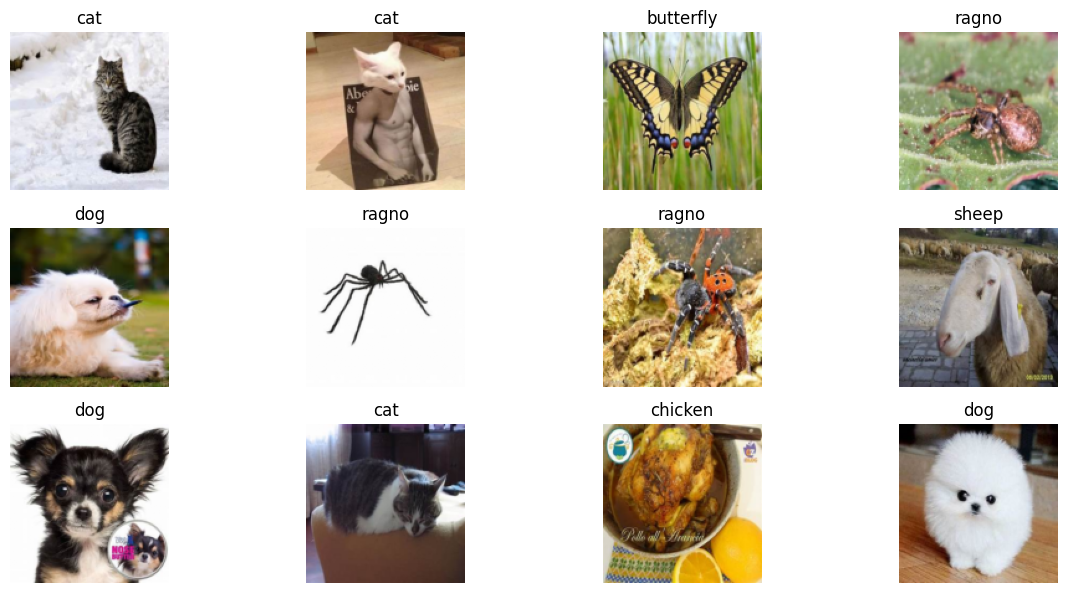

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Translation dictionary: Italian → English
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel"
}

# Rebuild dataset pointing to correct folder (adjust if needed)
dataset = datasets.ImageFolder("/kaggle/input/animals10/raw-img", transform=transform)

# Build mapping: label index → English class name
idx_to_english = {
    idx: translate.get(class_name, class_name)
    for class_name, idx in dataset.class_to_idx.items()
}

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get one batch
images, labels = next(iter(data_loader))

# Plot
plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(idx_to_english[labels[i].item()])  # Convert tensor to int
    plt.axis("off")

plt.tight_layout()
plt.show()


In [76]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Image parameters
img_size = (64, 64)  # Change this if you're not working with MNIST-style images
batch_size = 32

# Load dataset from folders (no batching so we get individual images)
dataset_path = "/kaggle/input/animals10/raw-img"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=img_size,
    batch_size=None,  # yields (image, label) per step
    shuffle=True
)

# Convert to NumPy arrays
x = []
y = []
for img, label in dataset:
    x.append(img.numpy())
    y.append(label.numpy())

# Fix indentation: convert after the loop
x = np.array(x)
y = np.array(y)

print("x shape:", x.shape)  # (num_samples, height, width, channels)
print("y shape:", y.shape)  # (num_samples,)

# Normalize pixel values
x = x / 255.0

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)


Found 26179 files belonging to 10 classes.
x shape: (26179, 64, 64, 3)
y shape: (26179,)
Train: (20943, 64, 64, 3) (20943,)
Test: (5236, 64, 64, 3) (5236,)


One hot encoding of labels

In [77]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


Model Initialization

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers  # To access layers more cleanly

# Define the number of output classes (e.g., 10 for Animals10 dataset or CIFAR-10)
num_classes = 10  # Set this to match your dataset

# Build the CNN model
model = Sequential([

    # Input layer specifying the shape of each image (28x28 RGB image)
    layers.Input(shape=(64, 64, 3)),

    # First convolutional block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # 32 filters with 3x3 kernel
    layers.MaxPooling2D(pool_size=(2, 2)),                     # Reduce spatial dimensions by 2
    layers.Dropout(0.3),                                       # Dropout to reduce overfitting

    # Second convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # 64 filters
    layers.MaxPooling2D(pool_size=(2, 2)),                     # Pooling layer
    layers.Dropout(0.3),                                       # Dropout again

    # Fully connected layers
    layers.Flatten(),                                          # Flatten the 2D feature maps into 1D
    layers.Dense(128, activation='relu'),                      # Dense hidden layer with ReLU
    layers.Dropout(0.5),                                       # Stronger dropout before output layer

    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax')
])


Model Compilation

Training with learning rate: 0.0001
Training with learning rate: 0.0005
Training with learning rate: 0.001
Training with learning rate: 0.002


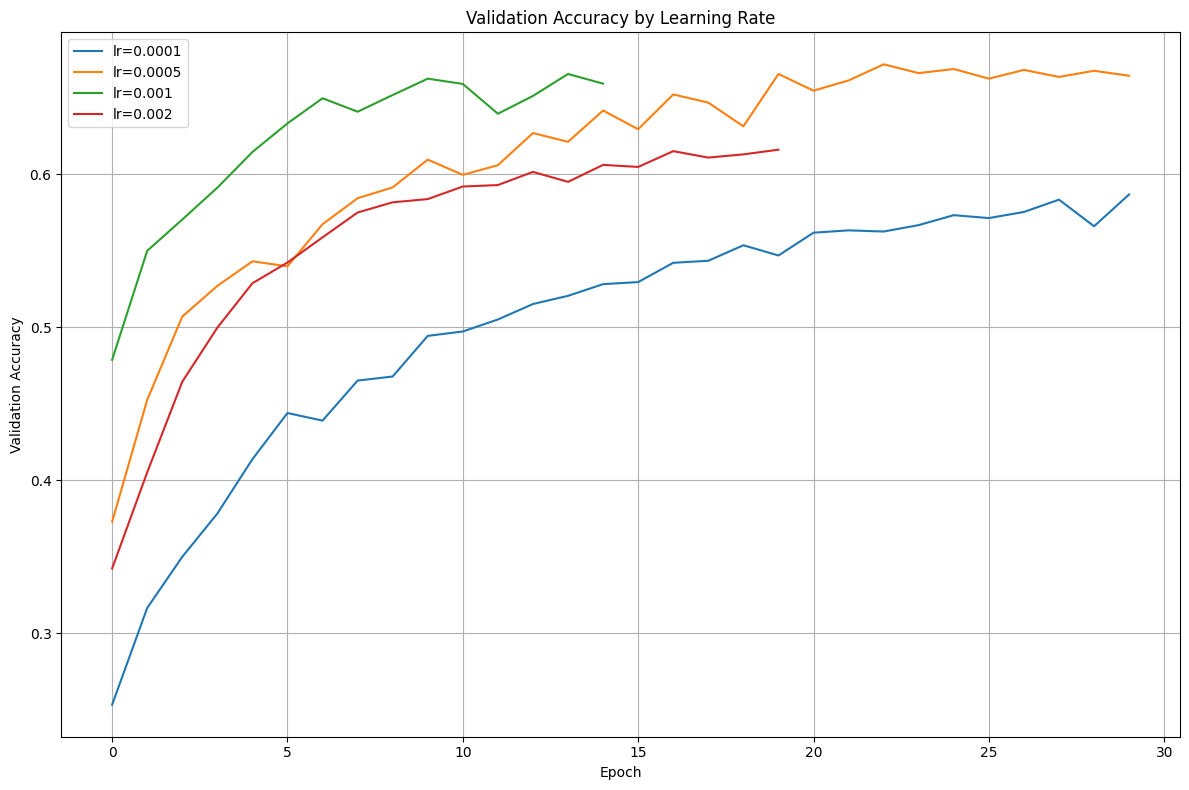


Best Learning Rate: 0.0005


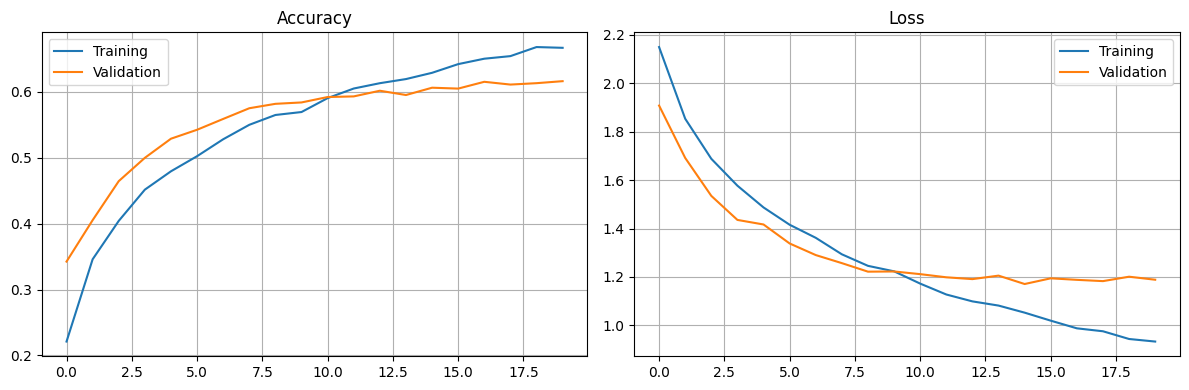


Final Validation Accuracies:
Learning Rate: 0.00050 -> Val Accuracy: 0.6719
Learning Rate: 0.00100 -> Val Accuracy: 0.6656
Learning Rate: 0.00200 -> Val Accuracy: 0.6161
Learning Rate: 0.00010 -> Val Accuracy: 0.5869


In [87]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#track all histories
histories = {}

# Simple fix: better learning rates
learning_rates = [0.0001, 0.0005, 0.001, 0.002]

plt.figure(figsize=(12, 8))
accuracies = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64,64, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # Reduced dropout
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # Reduced dropout
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        x_train, y_train_cat,
        epochs=35,
        batch_size=32,
        validation_data=(x_test, y_test_cat),
        callbacks=[early_stop],
        verbose=0
    )
    histories[lr] = history

    # track accuracy
    final_val_acc = max(history.history['val_accuracy'])  # Best accuracy instead of last
    accuracies[lr] = final_val_acc

    # Plot
    plt.plot(history.history['val_accuracy'], label=f"lr={lr}")

# Plot
plt.title("Validation Accuracy by Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plot accuracy/loss for the best learning rate
best_lr = max(accuracies, key=accuracies.get)
best_history = histories[best_lr]
print(f"\nBest Learning Rate: {best_lr}")

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print all accuracies
print("\nFinal Validation Accuracies:")
for lr, acc in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"Learning Rate: {lr:.5f} -> Val Accuracy: {acc:.4f}")

In [80]:
# Print model summary
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,879,328 (18.61 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,252,886 (12.41 MB)

In [81]:
#test the accuracy data
print("Data diagnostics:")
print(f"Train data shape: {x_train.shape}")
print(f"Train data range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Labels shape: {y_train_cat.shape}")
print(f"Number of classes: {y_train_cat.shape[1]}")

# Check if data is normalized
if x_train.max() > 1.0:
    print("❌ Data is NOT normalized - this is likely your main problem!")
    print("Fix: x_train = x_train / 255.0")
else:
    print("✅ Data appears normalized")

Data diagnostics:
Train data shape: (20943, 64, 64, 3)
Train data range: [0.000, 1.000]
Labels shape: (20943, 10)
Number of classes: 10
✅ Data appears normalized


Evaluation

In [82]:
test_loss,test_acc = model.evaluate(x_test, y_test_cat)
y_test_predict = model.predict(x_test)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6203 - loss: 1.1641
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Model Predicton

In [83]:
import numpy as np

y_pred_probs = model.predict(x_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


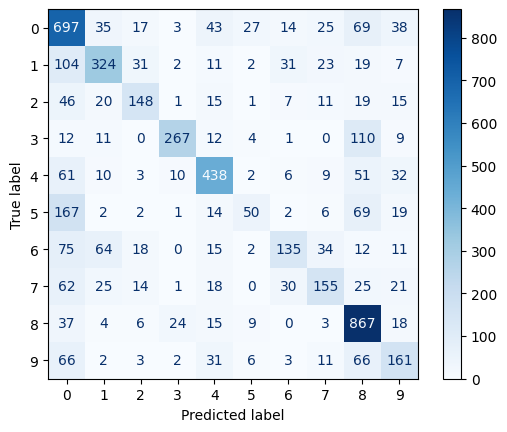

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

 Classification Report

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.72      0.61       968
           1       0.65      0.58      0.62       554
           2       0.61      0.52      0.56       283
           3       0.86      0.63      0.72       426
           4       0.72      0.70      0.71       622
           5       0.49      0.15      0.23       332
           6       0.59      0.37      0.45       366
           7       0.56      0.44      0.49       351
           8       0.66      0.88      0.76       983
           9       0.49      0.46      0.47       351

    accuracy                           0.62      5236
   macro avg       0.61      0.55      0.56      5236
weighted avg       0.62      0.62      0.60      5236



 Visualize Misclassified Samples

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


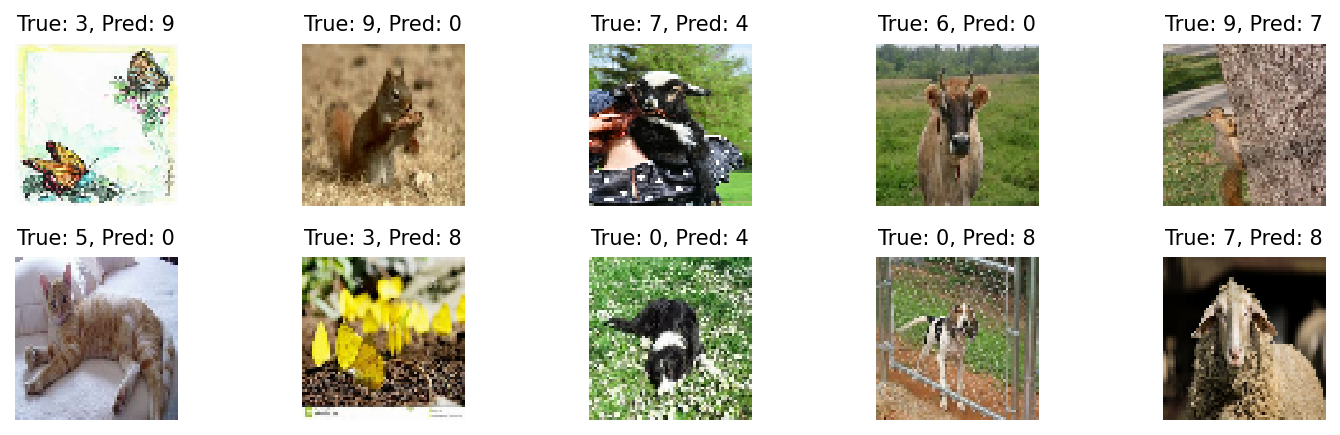

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Predict and identify misclassified samples
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plot first 10 misclassified color images clearly
plt.figure(figsize=(10, 3), dpi=150)  # Higher DPI for sharpness

for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx], interpolation='none')  # <– Critical: no blur
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_classes[idx]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
